In [1]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir("../..")
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/soutrik-vm-dev/code/Users/Soutrik.Chowdhury/langgraph_ventures


##### In this script we will build the langgraph orchestration system:
1. Load the tools the retriever tool and the tavily tool
2. Load the independent chains for each node
3. Create the conditional edges between the nodes
4. Create the graph
5. Create the graph executor

In [3]:
from src.utils import get_llm, get_embedder, timeit
from src.vector_db import VectorDBManager
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from langchain_community.tools.tavily_search import TavilySearchResults
from IPython.display import Image, display
from langchain_core.documents import Document
from typing import List, Dict, Any, Optional, Tuple
from src.query_router import get_question_router_chain
from src.doc_grader import get_doc_grader_chain
from src.query_rewriter import get_query_rewrite_chain
from src.doc_summarizer import get_doc_summarizer_chain
from src.response_scorer import get_response_scorer_chain

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
llm = get_llm()
embedder = get_embedder()

In [6]:
question_router_chain = get_question_router_chain(llm)
doc_grader_chain = get_doc_grader_chain(llm)
query_rewrite_chain = get_query_rewrite_chain(llm)
summarizer_chain = get_doc_summarizer_chain(llm)
scorer_chain = get_response_scorer_chain(llm)

In [7]:
vectordb_manager_new = VectorDBManager(embedder=embedder,
                                   collection_name="nutmeg",
                                   drop_old=False,
)

In [8]:
# vectordb_manager_new.check_collections()

In [9]:
# vectordb_manager_new.retrieve_similar(query="What is the latest news about the economy?")

In [10]:
web_search_retriever = TavilySearchResults(
    max_results=5, include_answer=False, include_raw_content=True, search_depth="basic"
)

In [11]:
class GraphState(TypedDict):
    """
    A state in the graph representing a node with a specific type and content.
    """

    question: str
    documents: list[Document]
    rewritten_question: Optional[str]
    summary: str
    citation: list[str]
    grade_score: Optional[str]
    hallucination: Optional[str]
    response_score: Optional[float]
    grading_iteration: Optional[int]
    hallucination_iteration: Optional[int]

In [12]:
# # Define the graph structure
# state = GraphState(
#     question="What are the potential benefits of investing in the financials sector under the new Republican administration",
#     documents=[
#         Document(
#             page_content="The financials sector is expected to benefit from...",
#             metadata={"source": "source1"},
#         ),
#         Document(
#             page_content="Investing in the financials sector can lead to...",
#             metadata={"source": "source2"},
#         ),
#     ],
#     rewritten_question="What are the advantages of investing in the financials sector with the new Republican administration?",
#     summary="The financials sector is expected to benefit from the new Republican administration's policies, which may lead to increased investment opportunities.",
#     citations=[
#         "Source 1: The financials sector is expected to benefit from...",
#         "Source 2: Investing in the financials sector can lead to...",
#     ],
#     grade_score="fully supported",
#     hallucination="no",
#     response_score=0.95,
# )

##### Tool Declaration

In [13]:
def vector_retriever(state: GraphState):
    """
    Function to retrieve documents from the vector store based on the question in the state using ensemble_retriever and save the documents in the state.
    """
    print("Vector Retriever")
    question = state["rewritten_question"] if "rewritten_question" in state else state["question"]
    print("Question used for vector retriever:", question)
    documents = vectordb_manager_new.retrieve_similar(question, k=5)

    return {"documents": documents, "question": question}

In [14]:
# op = vector_retriever(state)

In [15]:
# temp_content = "\n\n".join(
#     [f"Content idx: {i} - {doc.page_content}" for i, doc in enumerate(op["documents"])]
# )
# temp_source = "\n\n".join(
#     [
#         f"Source idx: {i} - {doc.metadata['source']}"
#         for i, doc in enumerate(op["documents"])
#     ]
# )
# temp_keyword = ",\n".join(
#     [
#         f"Keywords set: {i} - ({doc.metadata['keywords']})"
#         for i, doc in enumerate(op["documents"])
#     ]
# )

# print("Documents retrieved:")
# print(temp_content)
# print("\n\n")
# print("Sources retrieved:")
# print(temp_source)
# print("\n\n")
# print("Keywords retrieved:")
# print(temp_keyword)

In [16]:
def web_search(state: GraphState):
    """
    Function to retrieve documents from the web search based on the question in the state using web_search_retriever and save the documents in the state.
    """
    print("Web Search")
    question = state["question"]
    documents = web_search_retriever.invoke(question)
    lc_docs = [
        Document(page_content=doc["content"], metadata={"source": doc["url"]})
        for doc in documents
    ]

    return {"documents": lc_docs, "question": question}

In [17]:
# op = web_search(state)
# print("Documents retrieved:")
# print(op["documents"])

##### Nodes Declaration

In [18]:
def router_node(state: GraphState):
    """
    Function to route the question to the appropriate source based on the user's query.
    """
    print("Routing the question to the appropriate source...")
    question = state["question"]
    op = question_router_chain.invoke({"query": question})

    if op.source == "vector_retriever":
        print("Routing to vector_retriever...")
        return "vectordb"
    elif op.source == "web_search":
        print("Routing to web_search...")
        return "web"

In [19]:
def document_grader_node(state: GraphState):
    """
    Grades the retrieved documents for relevance to the user's question.
    Optimized for clarity, robustness, and consistent state updates.
    """
    print("Grading the retrieved documents...")
    question = state["rewritten_question"] if "rewritten_question" in state else state["question"]
    print("Question used for grading:", question)
    documents = state.get("documents", [])

    only_content = "\n\n".join(
        f"Content idx: {i} - {getattr(doc, 'page_content', '')}"
        for i, doc in enumerate(documents)
    )

    op = doc_grader_chain.invoke(
        {
            "context": only_content,
            "question": question,
        }
    )

    grade_score = getattr(op, "grade_score", None)
    print("Graded documents with score:", grade_score)

    grading_iteration = state.get("grading_iteration", 0) + 1

    return {
        "grade_score": grade_score,
        "grading_iteration": grading_iteration,
    }

In [20]:
def decide_to_generate_rewrite(state: GraphState):
    """
    Function to decide whether to generate a new query or rewrite the existing one based on the grading score.
    If grading_iteration crosses the limit, print a message.
    """
    grade_score = state.get("grade_score")
    grading_iteration = state.get("grading_iteration", 0)
    print("Grade score:", grade_score)
    print("Grading iteration:", grading_iteration)
    print("Deciding whether to generate or rewrite based on the grading score...")

    if grading_iteration > 2:
        print("Grading iteration exceeded the limit. Stopping further attempts.")
        return "generate"  # END can be used to stop the workflow
    if grade_score == "full_relevance":
        return "generate"
    elif grade_score == "partial_relevance":
        return "rewrite"
    elif grade_score == "no_relevance":
        return END

In [21]:
def query_rewriter_node(state: GraphState):
    """
    Function to rewrite the user's question based on the retrieved documents and their keywords.
    Optimized for robustness and clarity.
    """
    print("Rewriting the user's question...")
    question = state["rewritten_question"] if "rewritten_question" in state else state["question"]
    print("Question used for rewriting:", question)
    documents = state.get("documents", [])

    only_keyword = ",\n".join(
        f"Keywords set: {i} - ({doc.metadata.get('keywords', '')})"
        for i, doc in enumerate(documents)
    )

    op = query_rewrite_chain.invoke(
        {
            "context": only_keyword,
            "question": question,
        }
    )

    rewritten_question = getattr(op, "rewritten_query", "")
    print("Rewritten question:", rewritten_question)

    return {
        "rewritten_question": rewritten_question,
    }

In [22]:
def response_summarizer_node(state: GraphState):
    """
    Function to summarize the response based on the user's question and the retrieved documents.
    Optimized for robustness and clarity.
    """
    print("Summarizing the response...")
    question = state["rewritten_question"] if "rewritten_question" in state else state["question"]
    print("Question used for summarization:", question)
    documents = state.get("documents", [])

    only_content = "\n\n".join(
        f"Content idx: {i} - {getattr(doc, 'page_content', '')}"
        for i, doc in enumerate(documents)
    )

    only_citation = "\n\n".join(
        f"Source idx: {i} - {doc.metadata.get('source', '')}"
        for i, doc in enumerate(documents)
    )
    # print("Content used for summarization:", only_content)
    # print("Citations used for summarization:", only_citation)

    op = summarizer_chain.invoke(
        {
            "context": only_content,
            "question": question,
            "citation": only_citation,
        }
    )

    summary = getattr(op, "summary", "")
    citation = getattr(op, "citation", "")

    return {"summary": summary, "citation": citation}

In [23]:
def hallucination_grader_node(state: GraphState):
    """
    Checks for hallucinations in the summarized response and grades it.
    """
    print("Checking for hallucinations in the summarized response and grading it...")
    question = state["rewritten_question"] if "rewritten_question" in state else state["question"]
    print("Question used for hallucination grading:", question)
    summary = state.get("summary", "")
    documents = state.get("documents", [])

    only_content = "\n\n".join(
        [f"Content idx: {i} - {doc.page_content}" for i, doc in enumerate(documents)]
    )

    op = scorer_chain.invoke(
        {
            "response": summary,
            "question": question,
            "context": only_content,
        }
    )

    hallucination = getattr(op, "hallucination")
    response_score = getattr(op, "response_score")

    print("Hallucination:", hallucination)
    print("Response score:", response_score)

    hallucination_iteration = state.get("hallucination_iteration", 0) + 1

    return {
        "hallucination": hallucination,
        "response_score": response_score,
        "hallucination_iteration": hallucination_iteration,
    }


In [24]:
def decide_to_accept_reject(state: GraphState):
    """
    Decides whether to accept or reject the summarized response based on hallucination and grading score.
    """
    print(
        "Deciding whether to accept or reject the summarized response based on the grading score..."
    )
    hallucination = state.get("hallucination")
    response_score = state.get("response_score")
    hallucination_iteration = state.get("hallucination_iteration", 0)

    # print("Hallucination:", hallucination)
    # print("Response score:", response_score)
    print("Hallucination iteration:", hallucination_iteration)

    if hallucination_iteration > 2:
        print("Hallucination iteration exceeded the limit. Rejecting the response.")
        return "not_acceptable"
    if hallucination == "yes":
        print("Hallucination detected in the response.")
        return "not_acceptable"
    if response_score >= 0.7:
        print("Response is acceptable.")
        return "acceptable"
    print("Response is not acceptable, so rewriting the question.")
    return "rewrite_try"

In [25]:
def validate_response(response_dict):
    """
    Validates a response dictionary and sets summary and citation to None if hallucination is 'yes'.
    
    Args:
        response_dict (dict): A dictionary containing response data with keys like 'hallucination',
                              'summary', and 'citation'
    
    Returns:
        dict: The validated response dictionary with summary and citation set to None if hallucination is 'yes'
    """
    # Make a copy of the input dictionary to avoid modifying the original
    validated_response = response_dict.copy()
    
    # Check if hallucination is 'yes'
    if validated_response.get('hallucination') == 'yes':
        validated_response['summary'] = None
        validated_response['citation'] = None
        validated_response["grade_score"] = None
    
    return validated_response

##### Graph Declaration

In [26]:
# Start the workflow
workflow = StateGraph(GraphState)

In [27]:
###### Adding tool nodes

workflow.add_node(
    node="vector_retriever",
    action=vector_retriever,
)

workflow.add_node(
    node="web_search",
    action=web_search,
)

In [28]:
# build the first layer with conditonal edges for tool routing
workflow.add_conditional_edges(
    source=START,
    path=router_node,
    path_map={"vectordb": "vector_retriever", "web": "web_search"},
)

In [29]:
# adding node for doc grader
workflow.add_node(
    node="document_grader_node",
    action=document_grader_node,
)
# adding normal edge to connect the tool node to the doc grader
workflow.add_edge(
    start_key="vector_retriever",
    end_key="document_grader_node",
)

In [30]:
# add the node for query rewriter
workflow.add_node(
    node="query_rewriter_node",
    action=query_rewriter_node,
)
# add a reverse edge to retriever
workflow.add_edge(
    start_key="query_rewriter_node",
    end_key="vector_retriever",
)

In [31]:
# add the node for summarizer
workflow.add_node(
    node="response_summarizer_node",
    action=response_summarizer_node,
)

# add one edge to the summarizer from web_search
workflow.add_edge(
    start_key="web_search",
    end_key="response_summarizer_node",
)

In [32]:
# adding conditional edges to connect the doc grader to the query rewriter and summarizer
workflow.add_conditional_edges(
    source="document_grader_node",
    path=decide_to_generate_rewrite,
    path_map={
        "generate": "response_summarizer_node",
        "rewrite": "query_rewriter_node",
        END: END,
    },
)

In [33]:
# add the node after response summarizer
workflow.add_node(
    node="hallucination_grader_node",
    action=hallucination_grader_node,
)

# add the edge to the hallucination grader
workflow.add_edge(
    start_key="response_summarizer_node",
    end_key="hallucination_grader_node",
)

In [34]:
# add the conditional edges to decide to accept or reject the response
workflow.add_conditional_edges(
    source="hallucination_grader_node",
    path=decide_to_accept_reject,
    path_map={
        "acceptable": END,
        "not_acceptable": END,
        "rewrite_try": "query_rewriter_node",
    },
)

In [35]:
# compile the graph and check the graph
graph = workflow.compile()

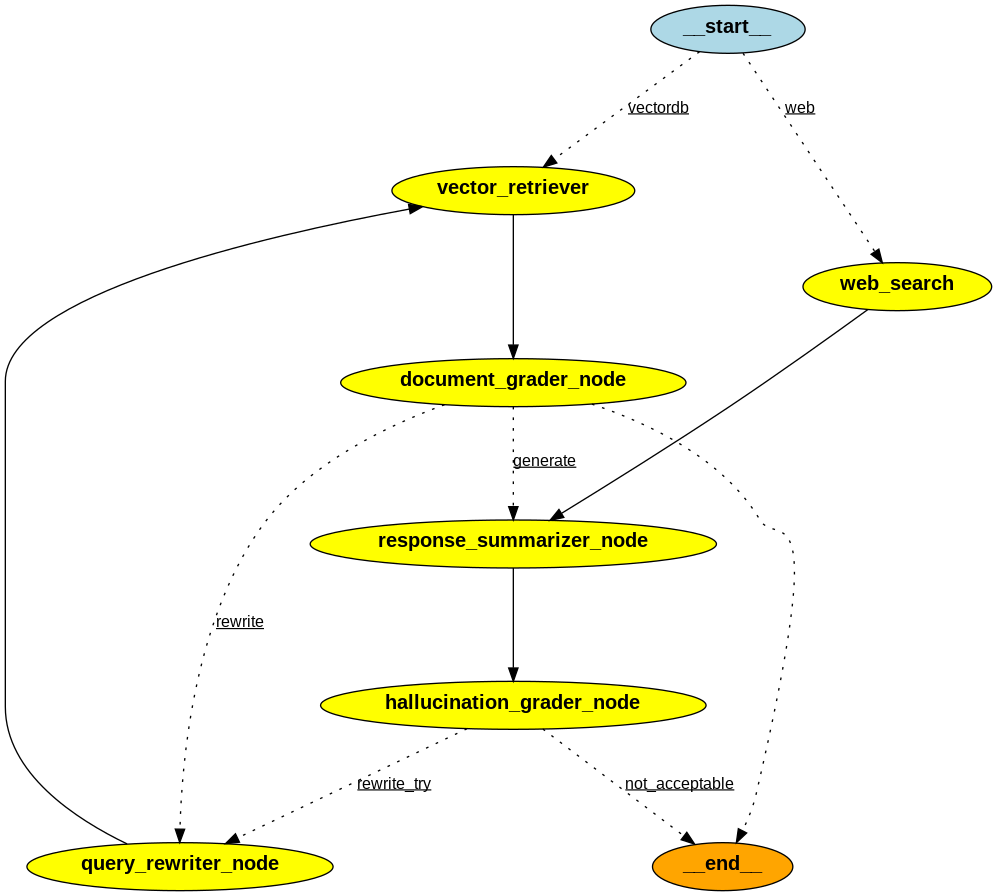

In [36]:
display(Image(graph.get_graph().draw_png()))

In [37]:
@timeit
def run_graph(graph, inputs):
    """
    Function to run the graph with the given inputs.
    """
    print("Running the graph...")

    # run the graph with the inputs

    op = graph.invoke(inputs)
    op = validate_response(op)
    return op

In [38]:
# legit question
inputs = {
    "question": "What are the potential benefits of investing in the financials sector under the new Republican administration",
}

# run the graph with the inputs
op = run_graph(graph, inputs)

Running the graph...
Routing the question to the appropriate source...
Routing to vector_retriever...
Vector Retriever
Question used for vector retriever: What are the potential benefits of investing in the financials sector under the new Republican administration
Grading the retrieved documents...
Question used for grading: What are the potential benefits of investing in the financials sector under the new Republican administration
Graded documents with score: full_relevance
Grade score: full_relevance
Grading iteration: 1
Deciding whether to generate or rewrite based on the grading score...
Summarizing the response...
Question used for summarization: What are the potential benefits of investing in the financials sector under the new Republican administration
Checking for hallucinations in the summarized response and grading it...
Question used for hallucination grading: What are the potential benefits of investing in the financials sector under the new Republican administration
Hallu

In [39]:
op

{'question': 'What are the potential benefits of investing in the financials sector under the new Republican administration',
 'documents': [Document(metadata={'title': 'Nutmeg investor update: March 2025 - Nutmeg', 'description': 'February was a busy month, with investors digesting a lot of geopolitical news. US stocks fell back, but European and Chinese equities made notable gains.', 'keywords': 'Nutmeg investor update March 2025 global stock markets European equities Chinese equities US stocks economic outlook portfolio adjustments European industrials financial sector Republican administration', 'source': 'https://www.nutmeg.com/nutmegonomics/nutmeg-investor-update-march-2025', 'language': 'en', 'summary': "The Nutmeg investor update for March 2025 highlights the mixed performance of global stock markets in February, with European and Chinese equities gaining while US stocks declined. The update also discusses the Nutmeg investment team's views on the US economic outlook, their por

In [40]:
# partial relevance question
inputs = {
    "question": "What is the reason for the financial markets to be volatile?",
}

op = run_graph(graph, inputs)

Running the graph...
Routing the question to the appropriate source...
Routing to vector_retriever...
Vector Retriever
Question used for vector retriever: What is the reason for the financial markets to be volatile?
Grading the retrieved documents...
Question used for grading: What is the reason for the financial markets to be volatile?
Graded documents with score: partial_relevance
Grade score: partial_relevance
Grading iteration: 1
Deciding whether to generate or rewrite based on the grading score...
Rewriting the user's question...
Question used for rewriting: What is the reason for the financial markets to be volatile?
Rewritten question: What factors are contributing to the volatility in financial markets, considering recent updates on stock market performance, Federal Reserve rate cuts, bond markets, and geopolitical uncertainties?
Vector Retriever
Question used for vector retriever: What factors are contributing to the volatility in financial markets, considering recent updates 

In [41]:
op

{'question': 'What factors are contributing to the volatility in financial markets, considering recent updates on stock market performance, Federal Reserve rate cuts, bond markets, and geopolitical uncertainties?',
 'documents': [Document(metadata={'language': 'en', 'summary': "The Nutmeg investor update for October 2024 reviews market performance in September, highlighting significant central bank announcements from the US Federal Reserve and the People's Bank of China, which led to positive investor reactions and market movements. The update also discusses the investment team's unchanged portfolio allocation and their focus on US technology stocks due to technological change.", 'keywords': "Nutmeg investor update October 2024 market performance central bank announcements US Federal Reserve People's Bank of China equity markets interest rates economic growth Chinese equities investment team portfolio allocation US technology stocks", 'title': 'Nutmeg investor update: October 2024 - Nu

# Dynamic Corrective  RAG Workflow Explanation

This LangGraph workflow implements an Adaptive RAG (Retrieval-Augmented Generation) System with the following components:

## 1. Router Node
- Receives the user question
- Uses an LLM-based router to determine retrieval strategy
- Routes to either the vector_retriever or web_search node

## 2. Vector Retriever Node
- Retrieves relevant documents from the vector store using an ensemble retriever
- Passes the documents and question to the next node

## 3. Web Search Node
- Retrieves relevant documents from the web using a search API
- Converts results into LangChain Document objects
- Passes the documents and question to the next node

## 4. Document Grader Node
- Grades document relevance to the question using an LLM-based grader
- Increments a grading iteration counter
- Passes the grade score and iteration count to the next step

## 5. Conditional Edge (decide_to_generate_rewrite)
- If documents are fully relevant or grading iteration > 2: proceed to generate response
- If partially relevant: rewrite query and retry retrieval
- If not relevant: end workflow

## 6. Query Rewriter Node
- Uses document keywords to rewrite the question for better retrieval
- Loops back to the vector retriever for another attempt

## 7. Response Summarizer Node
- Summarizes the answer using the question and retrieved documents
- Produces a summary and citations

## 8. Hallucination Grader Node
- Checks summary for hallucinations and scores the response
- Increments a hallucination iteration counter

## 9. Conditional Edge (decide_to_accept_reject)
- If response is acceptable (no hallucination, score ≥ 0.7): end workflow
- If not acceptable or hallucination iteration > 2: end workflow
- If not acceptable but not hallucinated: rewrite question and retry

## Summary
The graph adaptively routes questions, retrieves and grades documents, rewrites queries if needed, summarizes responses, and checks for hallucinations. It loops through retrieval and rewriting until a high-quality, non-hallucinated answer is produced or a retry limit is reached, ensuring robust and accurate RAG-based question answering.